AISC2007-WEEK5-ASSIGNMENT: model to predict if a person has Covid-19 or other infections or no lung infection from the lung xrays

LETS BEGIN BY IMPORTING SOME IMPORTANT LIBRARIES....AS ALWAYS

In [6]:
!pip install opencv-python
!pip install --upgrade albumentations
import os
import cv2
import numpy as np
from skimage import exposure, morphology
from skimage.filters import threshold_otsu
from albumentations import Compose, Rotate, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 81.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstalling pydantic-1.10.12:
      Successfully uninstall

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [29]:
def combine_image_and_mask(image_path, mask_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            raise FileNotFoundError("Image or mask not found")
        
        # Resizing images if needed
        image = cv2.resize(image, (150, 150))
        mask = cv2.resize(mask, (150, 150))
        
        # Normalizing and combine the image and mask
        combined = np.dstack((image, mask)) / 255.0
        return combined
    except Exception as e:
        print(f"Error processing {image_path} and {mask_path}: {e}")
        return None

def load_and_combine_class_data(data_dir, class_name):
    combined_data = []
    class_dir = os.path.join(data_dir, class_name)
    print(class_dir)
    images_dir = os.path.join(class_dir, 'images')
    masks_dir = os.path.join(class_dir, 'lung masks')
    
    image_files = os.listdir(images_dir)
    
    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        mask_path = os.path.join(masks_dir, image_file)
        
        if os.path.exists(mask_path):
            combined = combine_image_and_mask(image_path, mask_path)
            if combined is not None:
                combined_data.append(combined)
        else:
            print(f"Warning: Mask not found for image {image_file}")
    
    return np.array(combined_data)

NOW WE WILL APPLY AUGMENTATION, INTENSITY THRESHHOLDING,MORPHOLOGICAL OPERATIONS, GAUSSIAN BLUR TO THE COMBINED IMAGE....

In [48]:

def apply_augmentations(data):
    augmentations = Compose([
        Rotate(limit=30),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomBrightnessContrast(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5)
    ])
    augmented_data = [augmentations(image=img)['image'] for img in data]
    return np.array(augmented_data)

def preprocess_image(image):
    try:
        # Intensity thresholding
        thresh = threshold_otsu(image)
        binary = image > thresh
        
        # Morphological operations
        binary = morphology.remove_small_objects(binary, min_size=64, connectivity=2)
        
        # Histogram equalization
        equalized_image = exposure.equalize_hist(image)
        
        # Gaussian blur
        blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
        
        return blurred_image
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def preprocess_data(data):
    preprocessed_data = [preprocess_image(img[:,:,0]) for img in data]
    return np.array(preprocessed_data)

# Defining base directory
data_dir = "/Users/radu/downloads/val"




In [49]:
# Loading data for each class separately
normal_data = load_and_combine_class_data(data_dir, 'Normal')
print(normal_data)
covid_data = load_and_combine_class_data(data_dir, 'Covid-19')
non_covid_data = load_and_combine_class_data(data_dir, 'Non-Covid')

# Applying augmentations
augmented_normal_data = apply_augmentations(normal_data)
augmented_covid_data = apply_augmentations(covid_data)
augmented_non_covid_data = apply_augmentations(non_covid_data)

# Preprocessing data
preprocessed_normal_data = preprocess_data(normal_data)
preprocessed_covid_data = preprocess_data(covid_data)
preprocessed_non_covid_data = preprocess_data(non_covid_data)

# Printing shapes of the preprocessed data
print(f"Preprocessed Normal data shape: {preprocessed_normal_data.shape}")
print(f"Preprocessed Covid-19 data shape: {preprocessed_covid_data.shape}")
print(f"Preprocessed Non-Covid data shape: {preprocessed_non_covid_data.shape}")

/Users/radu/downloads/val/Normal
[[[[0.01960784 0.        ]
   [0.01568627 0.        ]
   [0.01568627 0.        ]
   ...
   [0.         0.        ]
   [0.         0.        ]
   [0.         0.        ]]

  [[0.01568627 0.        ]
   [0.01960784 0.        ]
   [0.01960784 0.        ]
   ...
   [0.         0.        ]
   [0.         0.        ]
   [0.         0.        ]]

  [[0.01568627 0.        ]
   [0.01960784 0.        ]
   [0.01960784 0.        ]
   ...
   [0.         0.        ]
   [0.         0.        ]
   [0.         0.        ]]

  ...

  [[0.24313725 0.        ]
   [0.21176471 0.        ]
   [0.16862745 0.        ]
   ...
   [0.         0.        ]
   [0.         0.        ]
   [0.         0.        ]]

  [[0.2627451  0.        ]
   [0.23921569 0.        ]
   [0.18039216 0.        ]
   ...
   [0.         0.        ]
   [0.         0.        ]
   [0.         0.        ]]

  [[0.21176471 0.        ]
   [0.2        0.        ]
   [0.14509804 0.        ]
   ...
   [0.         0.

In [50]:
from tensorflow.keras.utils import to_categorical  # will be loading libraries as per requirement

IMPLEMENTING CNN AND MODIFYING DATA AS PER REQUIREMENT..........

In [51]:

# Defining CNN architecture for multi-class classification
def build_multi_class_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Use softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modifing the data loading and preprocessing steps accordingly
# Loading and preprocessING data
X = np.concatenate([preprocessed_normal_data, preprocessed_covid_data, preprocessed_non_covid_data])
y = np.concatenate([np.zeros(len(preprocessed_normal_data)), np.ones(len(preprocessed_covid_data)), np.ones(len(preprocessed_non_covid_data)) * 2])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshaping input data to include the channel dimension
X_train = X_train.reshape(-1, 150, 150, 1)
X_val = X_val.reshape(-1, 150, 150, 1)

# Building CNN model for multi-class classification
input_shape = X_train[0].shape
num_classes = 3  # Number of classes
multi_class_cnn_model = build_multi_class_cnn(input_shape, num_classes)

# Training the model
history = multi_class_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                                    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])




# Converting integer labels to one-hot encoded vectors
y_val_one_hot = to_categorical(y_val, num_classes=3)





# Evaluating model performance
y_pred_prob = multi_class_cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
auc = roc_auc_score(y_val_one_hot, y_pred_prob, multi_class='ovr')

#auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
conf_matrix = confusion_matrix(y_val, y_pred)

print("AUC Score:", auc)
print("Confusion Matrix:")
print(conf_matrix)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.4321 - loss: 1.0797 - val_accuracy: 0.5987 - val_loss: 0.8815
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.6270 - loss: 0.8158 - val_accuracy: 0.7196 - val_loss: 0.6862
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.7299 - loss: 0.6701 - val_accuracy: 0.7445 - val_loss: 0.6210
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.7636 - loss: 0.5813 - val_accuracy: 0.7749 - val_loss: 0.5877
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - accuracy: 0.7882 - loss: 0.5217 - val_accuracy: 0.7574 - val_loss: 0.5855
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.7945 - loss: 0.5058 - val_accuracy: 0.7777 - val_loss: 0.5911
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - accuracy: 0.8099 - loss: 0.4565 - val_accuracy: 0.7970 - val_loss: 0.5809
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - accuracy: 0.8314 - loss: 0

AUC SCORE ACHIEVED: 0.947

LETS CHECK THE ROBUSTNESS OF MODEL AND PERFORM KFOLD VALIDATION.....AND CHECK THE SCORE

In [52]:
from sklearn.model_selection import KFold    # lets load this library


In [53]:
# Reshaping input data to include the channel dimension......it was really tricky here......
X = X[..., np.newaxis]

# Define CNN architecture
def build_multi_class_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Using softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Fold {fold}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = build_multi_class_cnn(X_train[0].shape, 3)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])
    
    y_val_one_hot = to_categorical(y_val, num_classes=3)
    
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    auc = roc_auc_score(y_val_one_hot, y_pred_prob, multi_class='ovr')
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    print("AUC Score:", auc)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    fold += 1

Fold 1


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.4357 - loss: 1.0764 - val_accuracy: 0.5830 - val_loss: 0.9804
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.6967 - loss: 0.7382 - val_accuracy: 0.7334 - val_loss: 0.6289
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.7585 - loss: 0.5992 - val_accuracy: 0.7509 - val_loss: 0.6134
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.7979 - loss: 0.5253 - val_accuracy: 0.7611 - val_loss: 0.6125
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.8024 - loss: 0.4817 - val_accuracy: 0.7860 - val_loss: 0.5875
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.8372 - loss: 0.4065 - val_accuracy: 0.7970 - val_loss: 0.5350
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 277ms/step - accuracy: 0.8544 - loss: 0.3707 - val_accuracy: 0.7970 - val_loss: 0.5492
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.8848 - loss: 0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.4466 - loss: 1.0533 - val_accuracy: 0.6882 - val_loss: 0.7647
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.6866 - loss: 0.7559 - val_accuracy: 0.7288 - val_loss: 0.6401
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - accuracy: 0.7537 - loss: 0.6172 - val_accuracy: 0.7362 - val_loss: 0.6208
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.7728 - loss: 0.5651 - val_accuracy: 0.7786 - val_loss: 0.5272
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.7971 - loss: 0.5111 - val_accuracy: 0.7934 - val_loss: 0.5039
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.8238 - loss: 0.4594 - val_accuracy: 0.7795 - val_loss: 0.5210
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.8330 - loss: 0.4039 - val_accuracy: 0.7980 - val_loss: 0.5379
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.8501 - loss: 0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - accuracy: 0.4830 - loss: 1.0126 - val_accuracy: 0.7119 - val_loss: 0.7073
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.7078 - loss: 0.7224 - val_accuracy: 0.7553 - val_loss: 0.6287
Epoch 3/20
 51/136 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.7666 - loss: 0.5961

KeyboardInterrupt: 

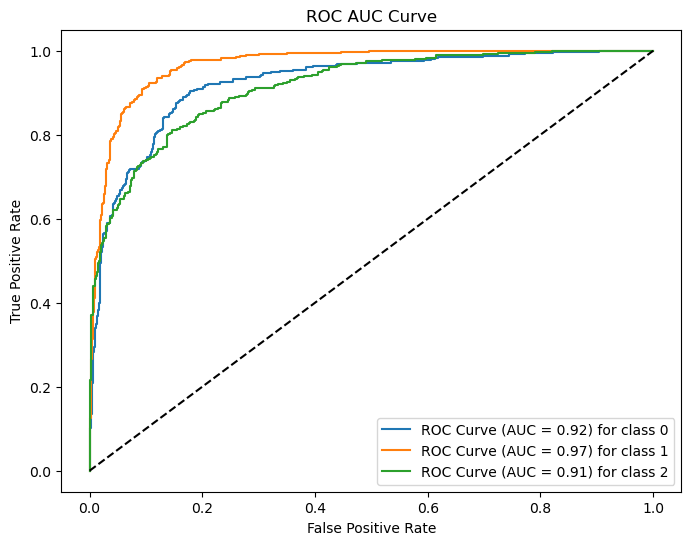

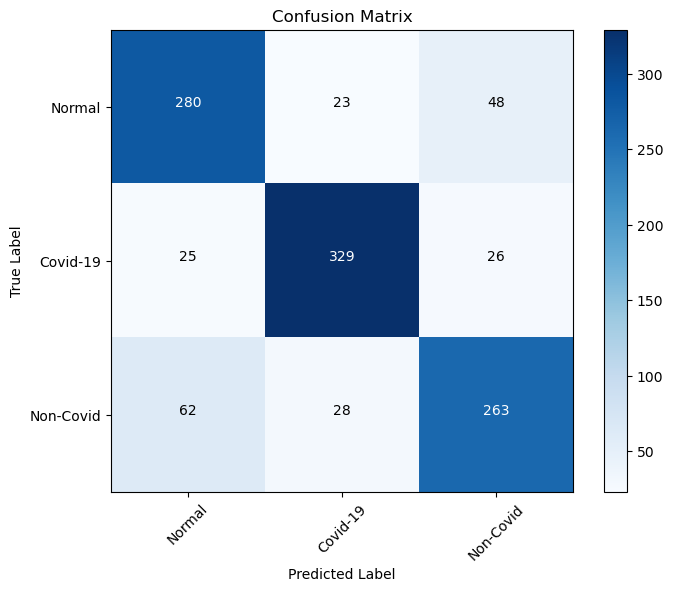

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# Visualize ROC AUC Curve
def plot_roc_auc(y_true, y_pred_prob):
    n_classes = y_pred_prob.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC Curve (AUC = {:.2f}) for class {}'.format(roc_auc[i], i))
        
    plt.plot([0, 1], [0, 1], 'k--')  # random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Visualize Confusion Matrix
def plot_confusion_matrix_custom(conf_matrix, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.show()

# Assuming y_val contains true labels and y_pred_prob contains predicted probabilities
# Plot ROC AUC Curve
plot_roc_auc(y_val_one_hot, y_pred_prob)

# Plot Confusion Matrix
plot_confusion_matrix_custom(conf_matrix, classes=['Normal', 'Covid-19', 'Non-Covid'])


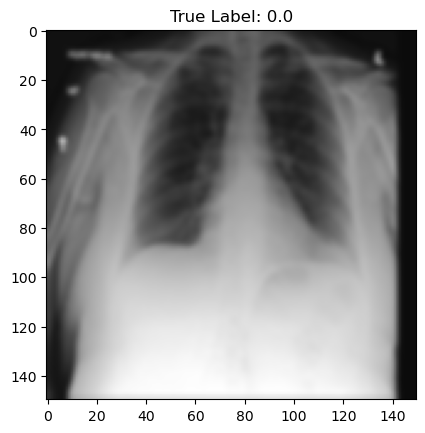

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

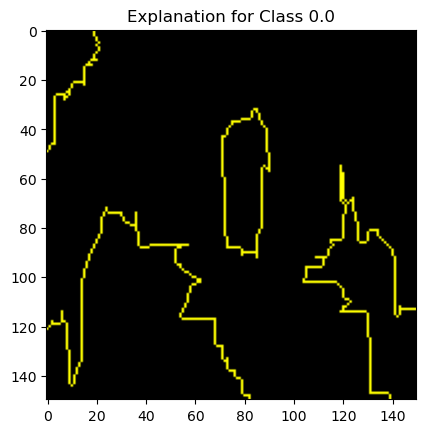

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


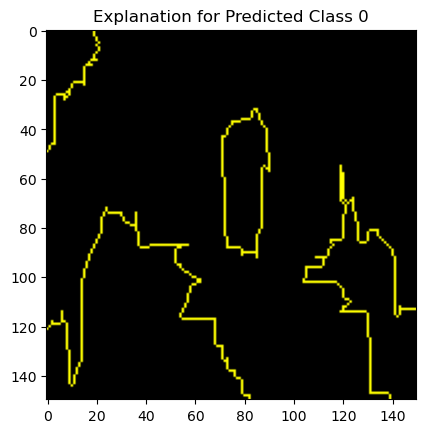

In [66]:
def predict_fn(images):
    images = np.array(images)
    # Convert RGB images back to grayscale
    if images.shape[-1] == 3:
        images = rgb2gray(images)
        images = np.expand_dims(images, axis=-1)  
    if images.max() > 1:
        images = images / 255.0  
 
    if len(images.shape) == 3:  
        images = np.expand_dims(images, axis=0)
    predictions = multi_class_cnn_model.predict(images)
    return predictions

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Convert grayscale image to RGB
def grayscale_to_rgb(image):
    if image.shape[-1] == 1:
        image = np.stack((image.squeeze(),) * 3, axis=-1)
    return image

# Select an image to explain
image_index = 0  
image = X_val[image_index]


if image.shape[-1] == 1 or len(image.shape) == 2:  # If it's a 2D grayscale image
    image_rgb = grayscale_to_rgb(image)
else:  
    image_rgb = image

image_class = y_val[image_index]


plt.imshow(image_rgb)
plt.title(f'True Label: {image_class}')
plt.show()


explanation = explainer.explain_instance(image_rgb, predict_fn, top_labels=3, hide_color=0, num_samples=1000)


temp, mask = explanation.get_image_and_mask(
    label=image_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'Explanation for Class {image_class}')
plt.show()

# Visualize the explanation for the predicted label
predicted_class = np.argmax(multi_class_cnn_model.predict(np.expand_dims(image, axis=0)))
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'Explanation for Predicted Class {predicted_class}')
plt.show()

PRETTY GOOD RESULTS SO FAR................TIME TO MOVE FORWARD WITH DNN MODEL

In [63]:
from sklearn.metrics import recall_score   # somehow i forgot this to load earlier.....as always.....never mind


In [64]:
LETS BEGIN WITH DNN MODEL .....

SyntaxError: invalid syntax (3586379514.py, line 1)

In [67]:
def build_deep_dnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Using softmax activation for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [68]:
# Building DNN model 
input_shape = X_train[0].shape
num_classes = 3  # Number of classes in our case
deep_dnn_model = build_deep_dnn(input_shape, num_classes)

# Training the model
history = deep_dnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.3443 - loss: 1.1660 - val_accuracy: 0.5383 - val_loss: 1.0223
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 215ms/step - accuracy: 0.5162 - loss: 0.9710 - val_accuracy: 0.5956 - val_loss: 0.8804
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.5946 - loss: 0.8994 - val_accuracy: 0.6473 - val_loss: 0.8403
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - accuracy: 0.6490 - loss: 0.8122 - val_accuracy: 0.6528 - val_loss: 0.7719
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.6726 - loss: 0.7739 - val_accuracy: 0.6704 - val_loss: 0.7390
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.6938 - loss: 0.7272 - val_accuracy: 0.7119 - val_loss: 0.6892
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.7239 - loss: 0.6706 - val_accuracy: 0.7350 - val_loss: 0.6448
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 235ms/step - accuracy: 0.7420 - loss: 0

In [38]:
# K-Fold validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Fold {fold}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    input_shape = X_train[0].shape
    num_classes = 3  # Number of classes
    model = build_deep_dnn(input_shape, num_classes)
    
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])
    
    y_val_one_hot = to_categorical(y_val, num_classes=3)
    
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    auc = roc_auc_score(y_val_one_hot, y_pred_prob, multi_class='ovr')
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    print("AUC Score:", auc)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    fold += 1

Fold 1


c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.3581 - loss: 1.1493 - val_accuracy: 0.5710 - val_loss: 0.9660
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.5316 - loss: 0.9591 - val_accuracy: 0.6227 - val_loss: 0.8953
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.5900 - loss: 0.8832 - val_accuracy: 0.6605 - val_loss: 0.8380
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6438 - loss: 0.8188 - val_accuracy: 0.6697 - val_loss: 0.7826
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.6630 - loss: 0.7910 - val_accuracy: 0.7066 - val_loss: 0.7085
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.6948 - loss: 0.7143 - val_accuracy: 0.7389 - val_loss: 0.6324
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7536 - loss: 0.6258 - val_accuracy: 0.7694 - val_loss: 0.5815
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.7727 - loss: 0

c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3761 - loss: 1.1521 - val_accuracy: 0.5581 - val_loss: 0.9194
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5445 - loss: 0.9439 - val_accuracy: 0.6448 - val_loss: 0.8294
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.6007 - loss: 0.8726 - val_accuracy: 0.6744 - val_loss: 0.7850
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6369 - loss: 0.8277 - val_accuracy: 0.7020 - val_loss: 0.7496
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6640 - loss: 0.7743 - val_accuracy: 0.7186 - val_loss: 0.6962
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.7139 - loss: 0.7039 - val_accuracy: 0.7417 - val_loss: 0.6443
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7461 - loss: 0.6451 - val_accuracy: 0.7638 - val_loss: 0.5781
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7490 - loss: 0

c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.3558 - loss: 1.1876 - val_accuracy: 0.5189 - val_loss: 0.9691
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.5387 - loss: 0.9503 - val_accuracy: 0.5596 - val_loss: 0.9023
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.5783 - loss: 0.8853 - val_accuracy: 0.6196 - val_loss: 0.8838
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6194 - loss: 0.8584 - val_accuracy: 0.6944 - val_loss: 0.7616
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6635 - loss: 0.7833 - val_accuracy: 0.7341 - val_loss: 0.7139
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.7062 - loss: 0.7090 - val_accuracy: 0.7424 - val_loss: 0.6819
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.7436 - loss: 0.6477 - val_accuracy: 0.7608 - val_loss: 0.6081
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7668 - loss: 0.5903 - val

c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.3746 - loss: 1.1317 - val_accuracy: 0.5614 - val_loss: 0.9419
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.5319 - loss: 0.9594 - val_accuracy: 0.5983 - val_loss: 0.8833
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.5829 - loss: 0.9056 - val_accuracy: 0.6427 - val_loss: 0.8069
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6363 - loss: 0.8238 - val_accuracy: 0.6925 - val_loss: 0.7322
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.6982 - loss: 0.7331 - val_accuracy: 0.7415 - val_loss: 0.6576
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.7271 - loss: 0.6797 - val_accuracy: 0.7562 - val_loss: 0.6249
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7500 - loss: 0.6153 - val_accuracy: 0.7562 - val_loss: 0.6159
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.7741 - loss: 0

c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.3604 - loss: 1.1283 - val_accuracy: 0.5300 - val_loss: 0.9275
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.5433 - loss: 0.9381 - val_accuracy: 0.6297 - val_loss: 0.8592
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6173 - loss: 0.8711 - val_accuracy: 0.6741 - val_loss: 0.7461
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.6336 - loss: 0.8385 - val_accuracy: 0.6759 - val_loss: 0.7464
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6600 - loss: 0.7831 - val_accuracy: 0.7101 - val_loss: 0.7298
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.6820 - loss: 0.7417 - val_accuracy: 0.7258 - val_loss: 0.7117
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.7004 - loss: 0.7267 - val_accuracy: 0.7322 - val_loss: 0.6700
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.7190 - loss: 0.6810 - val

VALIDATION RESULTS ARE SATISFYING......MODEL IS PERFORMING WELL.....
NOW LETS PLOT ROC-AUC CURVE AND CONFUSION MATRIX .....TO VISUALIZE PERFORMANCE OF DNN MODEL

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
AUC Score: 0.9379947928424212
Recall Score: 0.8208679593721145
Confusion Matrix:
[[271  24  23]
 [ 23 349  32]
 [ 59  33 269]]


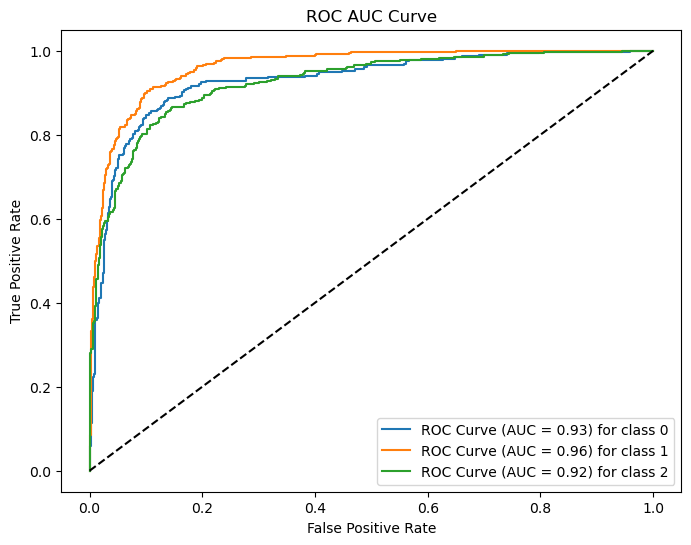

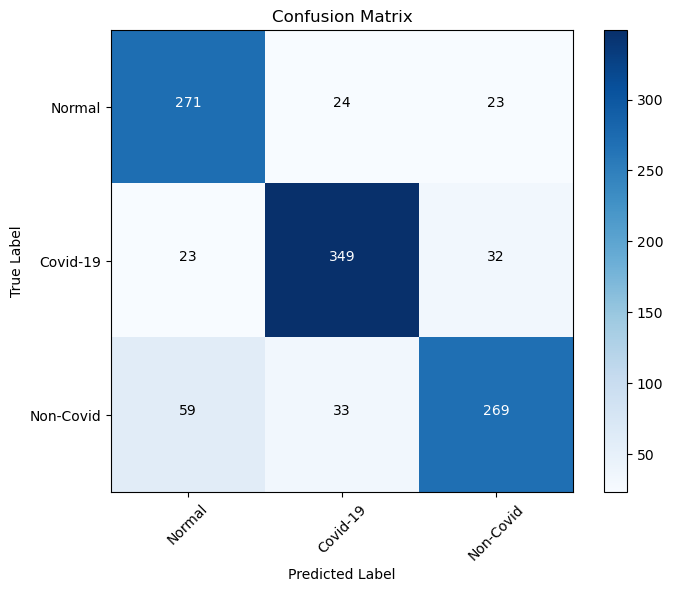

In [69]:
# Converting integer labels to one-hot encoded vectors for ROC AUC calculation
y_val_one_hot = to_categorical(y_val, num_classes=3)

# Evaluating model performance
y_pred_prob = deep_dnn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
auc_score = roc_auc_score(y_val_one_hot, y_pred_prob, multi_class='ovr')
recall = recall_score(y_val, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_val, y_pred)

print("AUC Score:", auc_score)
print("Recall Score:", recall)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing ROC AUC Curve
def plot_roc_auc(y_true, y_pred_prob):
    n_classes = y_pred_prob.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC Curve (AUC = {:.2f}) for class {}'.format(roc_auc[i], i))
        
    plt.plot([0, 1], [0, 1], 'k--')  # random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Visualizing Confusion Matrix
def plot_confusion_matrix_custom(conf_matrix, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.show()

# Ploting ROC AUC Curve
plot_roc_auc(y_val_one_hot, y_pred_prob)

# Ploting Confusion Matrix
plot_confusion_matrix_custom(conf_matrix, classes=['Normal', 'Covid-19', 'Non-Covid'])


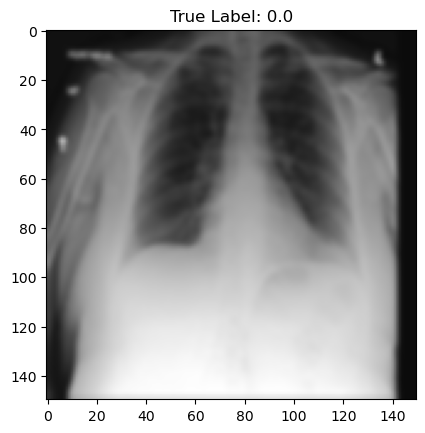

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

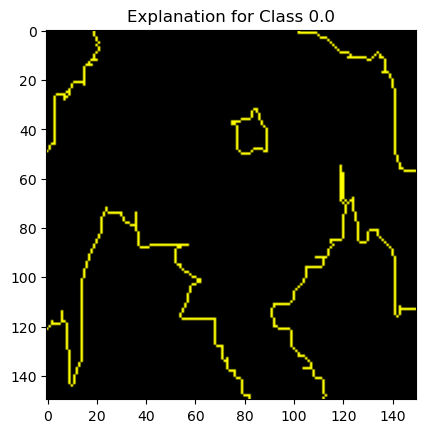

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


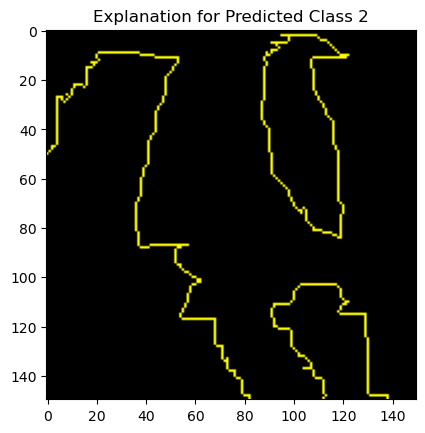

In [70]:
def predict_fn(images):
    images = np.array(images)
    # Convert RGB images back to grayscale
    if images.shape[-1] == 3:
        images = rgb2gray(images)
        images = np.expand_dims(images, axis=-1)  
    if images.max() > 1:
        images = images / 255.0  
 
    if len(images.shape) == 3:  
        images = np.expand_dims(images, axis=0)
    predictions = model.predict(images)
    return predictions

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Convert grayscale image to RGB
def grayscale_to_rgb(image):
    if image.shape[-1] == 1:
        image = np.stack((image.squeeze(),) * 3, axis=-1)
    return image

# Select an image to explain
image_index = 0  
image = X_val[image_index]


if image.shape[-1] == 1 or len(image.shape) == 2:  # If it's a 2D grayscale image
    image_rgb = grayscale_to_rgb(image)
else:  
    image_rgb = image

image_class = y_val[image_index]


plt.imshow(image_rgb)
plt.title(f'True Label: {image_class}')
plt.show()


explanation = explainer.explain_instance(image_rgb, predict_fn, top_labels=3, hide_color=0, num_samples=1000)


temp, mask = explanation.get_image_and_mask(
    label=image_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'Explanation for Class {image_class}')
plt.show()

# Visualize the explanation for the predicted label
predicted_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'Explanation for Predicted Class {predicted_class}')
plt.show()

AUC SCORE :0.9357
RECALL SCORE: 0.8191          .......NOT THAAT BAD....

SO FAR FOLLOWING CRITERIA IS MET..........

Basic Preprocessing such as Scaling and Image Resizing Done

Further preprocessing done such as image augmentation

Advanced Preprocessing done to combine data from both images

Detailed Preprocessing including Intensity Thresholds, Histogram equalization and Gaussian Blur


CNN implemented

CNN implemented well, AUC and Confusion matrix built

CNN implemented and tuned well, handling overfitting/underfitting, using both images if needed

Really-well tuned CNN, apt architecture to achieve strong performance, cross validation performed

 DNN built

DNN with Dropouts, multiple layers producing decent accuracy and recall, AUC and Confusion Matrix built

DNN tuned, using both images if needed, handling overfitting and underfitting

DNN with strong accuracy and recall, really well tuned, apt architecture for the dataset, cross validation performed